# Periodic stimulus

In [1]:
import numpy as np 
import scipy as sp
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN


import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx

from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt
import diffrax
import jax
from jax import lax, vmap, jit
import jax.random as random
from jax.experimental import sparse


In [2]:
#alternative laplacian to be checked

def generate_laplacian(N, M, conduction_block_threshold, sparse_matrix=False, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks

N_x=200
N_y=200
L1, c1=generate_laplacian(N_x, N_x, 0.5, sparse_matrix=True,seed=2)
#plt.imshow(L1.todense())


In [40]:

def FHN_graph(t, y, args):
    N, a, b, e, Du, L, c_blocks = args 
    u = y[:N]
    v = y[N:]
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)

    return jnp.append(du, dv)

def solve_heart(N=200*200, a=3, b=0.2, e=1e-2, Du=0.2, T=6000, L=None, c1=None, max_steps=1000000, save_points_per_segment=2000,
                solver=diffrax.Dopri8(), rtol=1e-6, atol=1e-7, dt0=1e-2):
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)

    # Calculate indices outside the periodic_stimulus function
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]

    term = ODETerm(FHN_graph)

    def run_segment(carry, t_start):
        y0, all_solutions, idx = carry
        y0 = jax.lax.cond(t_start == 0,
                          lambda _: jnp.zeros(2 * N, dtype=jnp.float32).at[indices].set(0.1),
                          lambda y0: y0,
                          y0)
        t_end = t_start + 1500
        saveat = SaveAt(ts=jnp.linspace(t_start, t_end, save_points_per_segment))  # Save specified points for each segment
        sol = diffeqsolve(term, solver, t_start, t_end, dt0, y0, args=(N, a, b, e, Du, L, c1),
                          saveat=saveat, max_steps=max_steps, stepsize_controller=stepsize_controller)
        all_solutions = jax.lax.dynamic_update_slice(all_solutions, sol.ys, [idx, 0])
        y0 = sol.ys[-1]

        # Apply stimulus to the specified indices
        y0 = jax.lax.cond(t_start == 0,
                          lambda y0: y0.at[indices].set(0.1),
                          lambda y0: y0.at[indices].add(0.1),
                          y0)

        return (y0, all_solutions, idx + sol.ys.shape[0]), None

    # Preallocate the array for all_solutions with the correct shape
    num_segments = T // 1500
    segment_length = save_points_per_segment  # Save specified points for each segment
    initial_solutions = jnp.empty((num_segments * segment_length, 2 * N), dtype=jnp.float32)
    carry = (jnp.zeros(2 * N, dtype=jnp.float32), initial_solutions, 0)

    # Run the simulation in segments using jax.lax.scan
    t_starts = jnp.arange(0, T, 1500)
    carry, _ = jax.lax.scan(run_segment, carry, t_starts)

    # Extract the full solution
    full_solution = carry[1]

    return full_solution



In [41]:

N_y=200
N=N_x*N_y
dts=500
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0,sparse_matrix=True, seed=2)
sol = solve_heart(T=4500,N=N,a=3,b=0.05,Du=0.04, L=L1,c1=c1,save_points_per_segment=dts)
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0.3,sparse_matrix=True, seed=2)
sol1=solve_heart(T=4500,N=N,a=3,b=0.05,Du=0.04, L=L1,c1=c1,save_points_per_segment=dts)
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0.5,sparse_matrix=True, seed=3)
sol2=solve_heart(T=4500,N=N,a=3,b=0.05,Du=0.04, L=L1,c1=c1,save_points_per_segment=dts)
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0.7,sparse_matrix=True, seed=4)
sol3=solve_heart(T=4500,N=N,a=3,b=0.05,Du=0.04, L=L1,c1=c1,save_points_per_segment=dts)

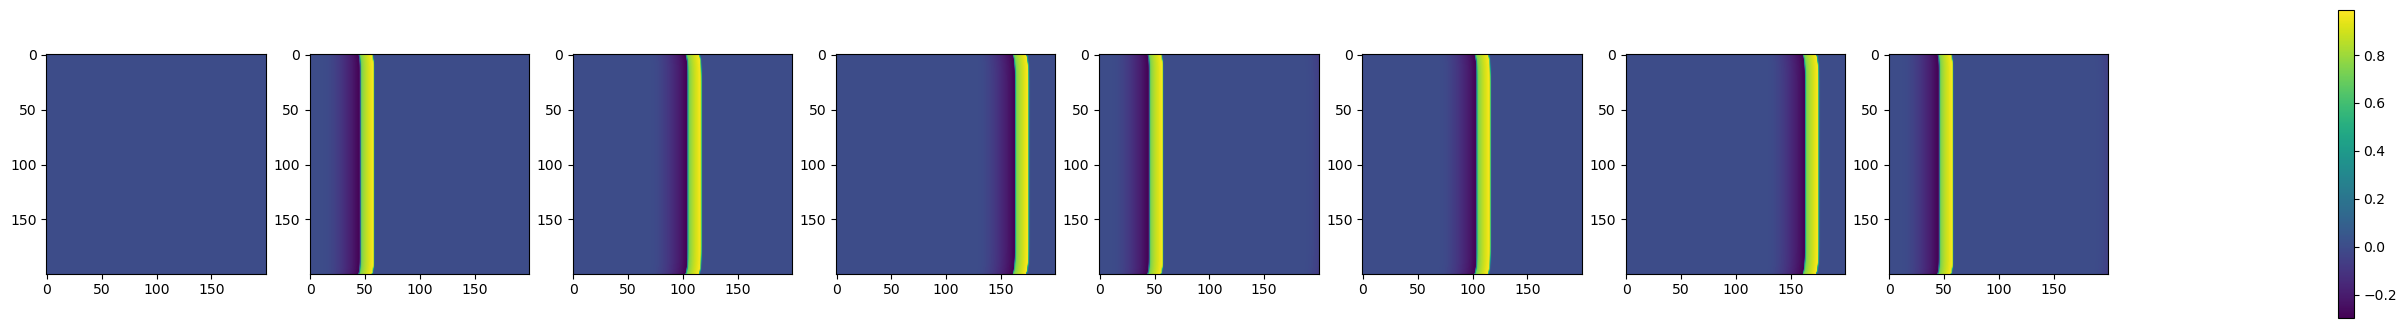

In [30]:
fig, axs = plt.subplots(1,9,figsize=(30,4))
min = sol.min()
max = sol.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol[int((i/len(axs)*len(sol))),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])
#To have arrhythmias; a=3, b=0.05, Du=0.04, cd=0.5. With cd=0.59 I don't have conduction anymore

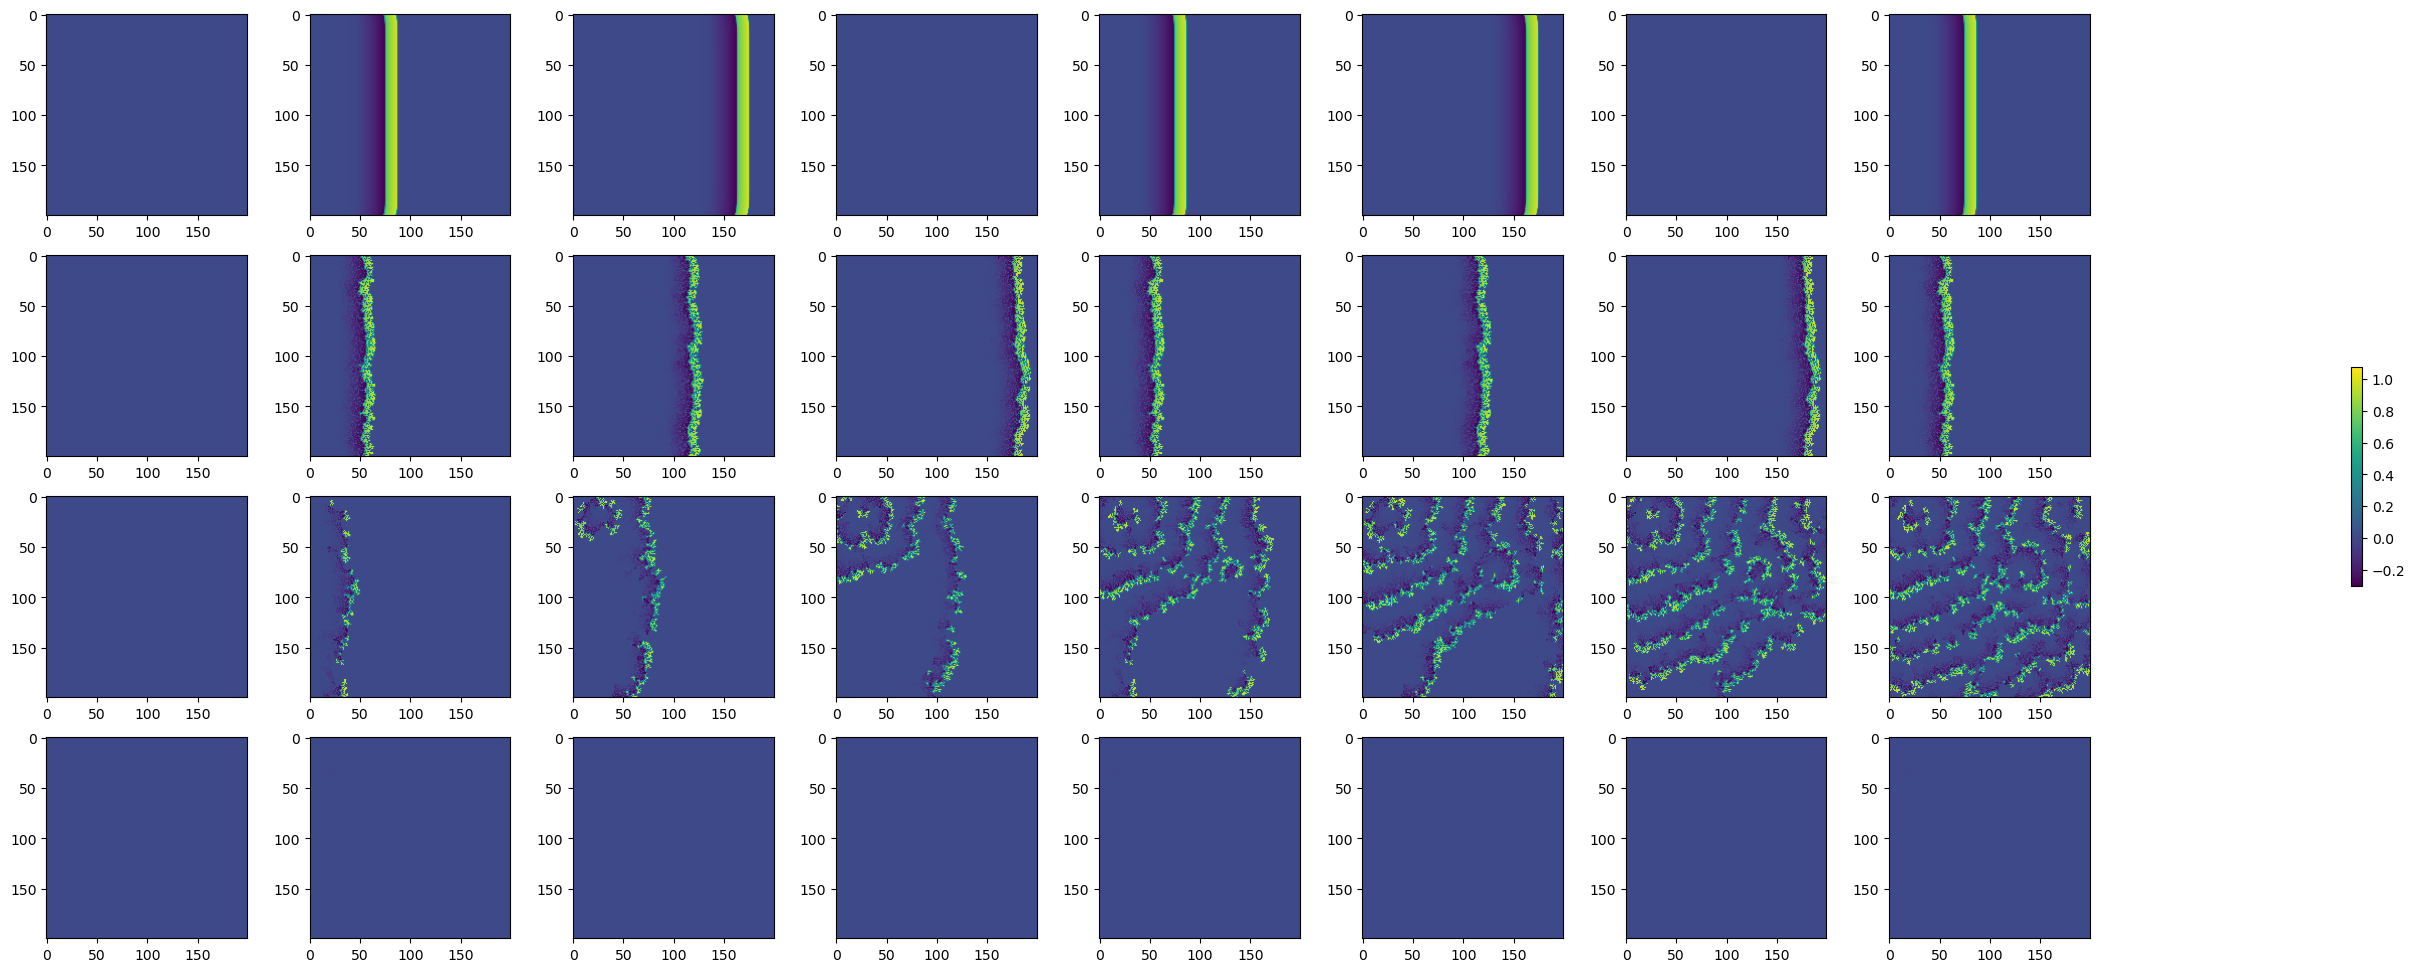

In [ ]:
fig, axs = plt.subplots(4, 9, figsize=(30, 12))
min_val = jnp.min(jnp.array([sol.min(),sol1.min(), sol2.min(), sol3.min()]))
max_val = jnp.max(jnp.array([sol.min(),sol1.max(), sol2.max(), sol3.max()]))
for j, solution in enumerate([sol,sol1, sol2, sol3]):
    for i, ax in enumerate(axs[j, :-1]):
        im = ax.imshow(solution[int((i / len(axs[j]) * len(solution))), :N].reshape(N_x, N_y), vmin=min_val, vmax=max_val)
    axs[j, -1].axis('off')

fig.colorbar(im, ax=axs[:, -1], fraction=0.1, pad=0.04)  # Adjusted fraction for a bigger colorbar
plt.show()

# Entropy calculation

In [ ]:
# entropy calculations without going to rate or activity
@jit
def calculate_entropy(power_spectrum):
    '''
    Calculate the entropy of a power spectrum.
    Parameters:
    power_spectrum (jax.numpy.ndarray): The power spectrum of a signal.
    Returns:
    float: The entropy of the power spectrum.
    '''
    epsilon = 1e-12  # Small constant to prevent division by zero
    
    entropy = -jnp.sum(power_spectrum * jnp.log(power_spectrum + epsilon))  # Calculate entropy
    return jnp.abs(entropy)  # Ensure entropy is not negative


@jit
def process_element(array, i, j):
    '''
    Process a single element of an array to calculate its Shannon entropy.
    '''
    fft_result_shifted = jnp.fft.fftshift(jnp.fft.fft(array[i, j, :]))  # FFT and shift in one line
    power_spectrum = jnp.abs(fft_result_shifted) ** 2
    epsilon = 1e-12  # Small constant to prevent division by zero
    power_spectrum /= jnp.sum(power_spectrum) + epsilon  # Normalize power spectrum
    
    # Check if the power spectrum is normalized
    power_spectrum_sum = jnp.sum(power_spectrum)
    power_spectrum_normalized = jnp.allclose(power_spectrum_sum, 1.0, atol=1e-5)
    
    # Calculate entropy or return NaN if not normalized
    entropy = lax.cond(
        power_spectrum_normalized,
        lambda _: calculate_entropy(power_spectrum),
        lambda _: jnp.nan,
        operand=None
    )
    return entropy


def average_entropy(array, c1):
    '''
    Calculate the average Shannon entropy of the power spectrum of the elements of an array disregarding the ones that are conduction blocks.
    Parameters:
    - array (jax.numpy.ndarray): A 3D array of shape (N, M, T) where N is the number of rows, M is the number of columns, and T is the number of time steps.
    - c1 (jax.numpy.ndarray): A binary matrix of shape (N, M) where True values indicate conduction blocks.
    Returns:
    - average_entropy (float): The average Shannon entropy of the power spectrum of the elements of the array.
    '''
    N, M, T = array.shape
    
    # Vectorized processing of all elements
    vectorized_process = vmap(lambda i: vmap(lambda j: process_element(array, i, j))(jnp.arange(M)))(jnp.arange(N))
    # Mask out elements where c1 is True
    masked_entropy = jnp.where(c1, jnp.nan, vectorized_process)
    
    # Calculate the mean entropy, ignoring NaN values
    average_entropy = jnp.nanmean(masked_entropy)
    return average_entropy

In [45]:
results_u = []
results_v=[]
dts=1000 #number of time steps simulation part
tdts=5000 #number of time steps whole simulation
# Loop over conduction threshold values
for conduction_threshold in jnp.arange(0, 0.8, 0.01):
    seed = int(conduction_threshold * 10)
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=conduction_threshold, sparse_matrix=True, seed=seed)   
    
    sol = solve_heart(T=7500,a=3,b=0.05,Du=0.04, L=L1, c1=c1,save_points_per_segment=dts)
    u_sol = sol[:,:N].T 
    v_sol = sol[:,N:].T

    u_sol=u_sol.reshape(N_x, N_y, tdts)
    v_sol=v_sol.reshape(N_x, N_y, tdts)

    
    avg_entropy_u = average_entropy(u_sol, c1)
    avg_entropy_v = average_entropy(v_sol, c1)
    
    results_u.append( avg_entropy_u)
    results_v.append(avg_entropy_v)

results_u = jnp.array(results_u)
results_v = jnp.array(results_v)

60
60


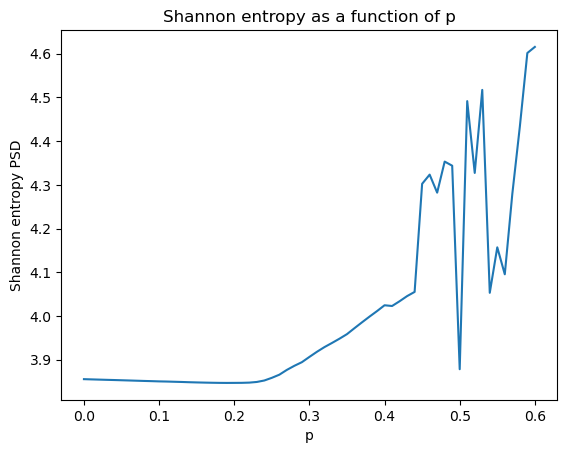

In [54]:
minu=np.min(results_u)
maxu=np.max(results_u)
#minv=np.min(entropy_v)
#maxv=np.max(entropy_v)
print(np.argmax(results_u))
print(np.argmax(results_v))
plt.plot(np.arange(0,0.61,0.01),results_u[:61],label='Entropy of u')
##plt.plot(np.arange(0,0.80,0.01),results_v,label='Entropy of v')
plt.xlabel('p')
plt.ylabel('Shannon entropy PSD')
#plt.legend()
plt.title('Shannon entropy as a function of p')
plt.show()


In [5]:
N=200*200

## Stochastic heart

In [13]:
import jax.numpy as jnp
import jax.random as random
from jax import lax

def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - Du: Diffusion coefficient
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=None, c1=None, sigma=0.0001, stimulus_time=1000, delta_t=0.1, total_time=3000.0, key=random.PRNGKey(0)):
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)
        
    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    def scan_fn(carry, step):
        u, v, key = carry
        key, subkey = random.split(key)

        # Apply stimulus to the specified indices
        u = jax.lax.cond((step > 0) & (step % int(stimulus_time / delta_t) == 0),
                          lambda u: u.at[indices].add(0.1),
                          lambda u: u,
                          u)

        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        return (u, v, key), (u, v)

    # Create a range of steps
    steps = jnp.arange(num_steps)

    # Run the scan function
    (u, v, _), (u_trajectory, v_trajectory) = lax.scan(scan_fn, (u, v, key), steps)

    return u_trajectory, v_trajectory



In [14]:
delta_t=0.1
sol=[]

for i in range(2): 
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=0.5, sparse_matrix=True, seed=2)
    u_sol, v_sol = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=delta_t, total_time=3000, stimulus_time=1000)
    sol.append(u_sol[:,2000])
    delta_t+=0.01


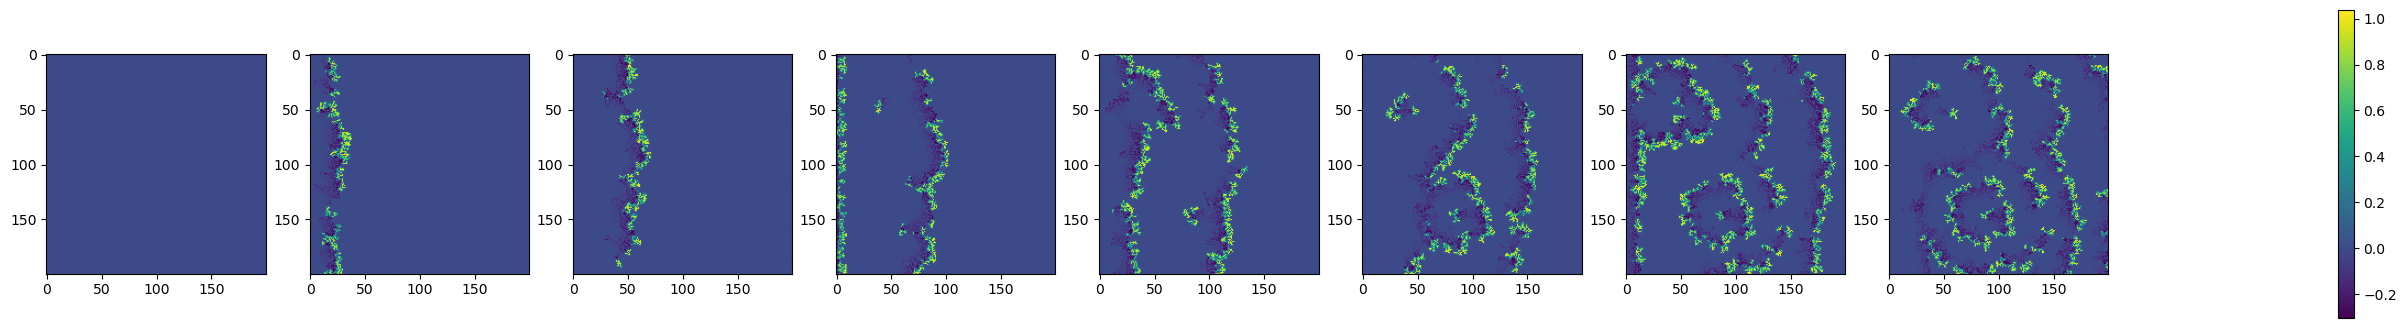

In [16]:
fig, axs = plt.subplots(1,9,figsize=(30,4))
min = u_sol.min()
max = u_sol.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(u_sol[int((i/len(axs)*int(3000/0.1))),:].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


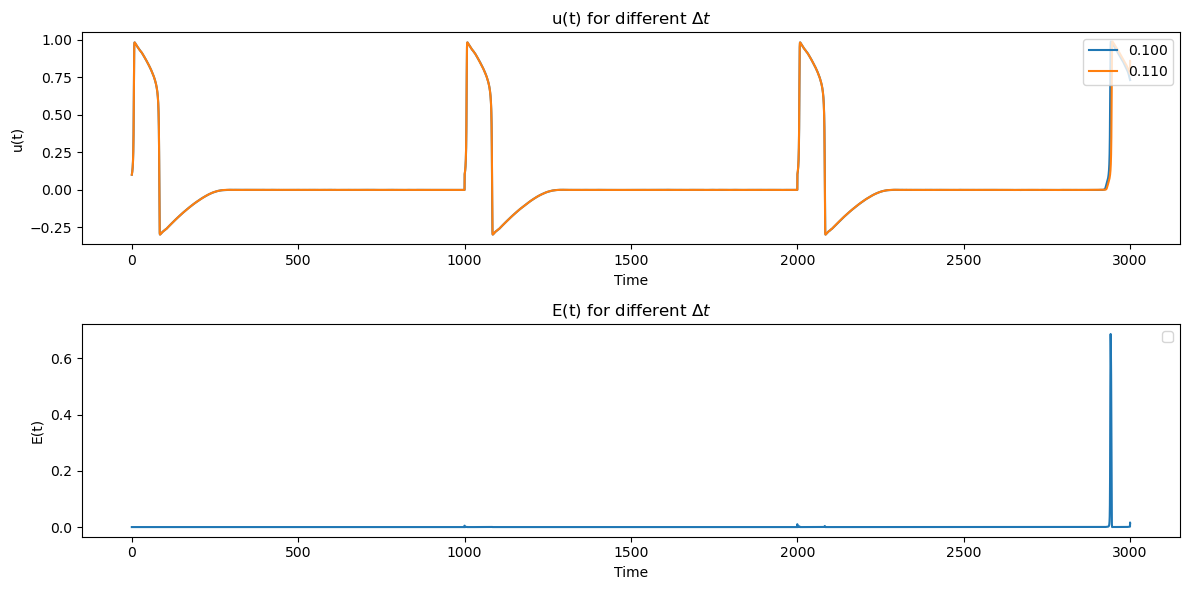

In [15]:

from scipy.interpolate import interp1d

time1=np.linspace(0, 3000, int(3000 / (0.1 )))
time2=np.linspace(0, 3000, int(3000 / (0.1 +  0.01)))
# Define the common time points
common_time = np.linspace(0, min(time1[-1], time2[-1]), num=min(len(time1), len(time2)))

# Interpolate both arrays to the common time points
interpolator1 = interp1d(time1, sol[0], kind='linear', fill_value="extrapolate")
interpolator2 = interp1d(time2, sol[1], kind='linear', fill_value="extrapolate")

sol1_common = interpolator1(common_time)
sol2_common = interpolator2(common_time)

# Perform the subtraction
s = (sol1_common - sol2_common)**2


for i in range(1):
    plt.figure(figsize=(12, 6))
    
    # Plot the time series
    plt.subplot(2, 1, 1)
    for j in range(2):
        plt.plot(np.linspace(0, 3000, int(3000 / (0.1 + j * 0.01))), sol[j][:], label=f"{0.1 + j * 0.01:.3f}")
    plt.xlabel('Time')
    plt.ylabel('u(t)')
    plt.legend(loc='upper right')
    plt.title(r'u(t) for different $\Delta t$')

    # Plot the histograms
    plt.subplot(2, 1, 2)
    '''
    for j in range(3):
        plt.hist(sol[j], bins=3000, alpha=0.75, label=r'$\Delta t$='+f'{0.05 + j * 0.01:.3f}', histtype='step')
        peak_values = sol[j][(sol[j] > -0.01) & (sol[j] < 0.01)]
        variance = np.var(peak_values)
        print(r'Variance of the peak around 0 for $\Delta t$'+f'={0.05 + j * 0.01:.3f}: {variance:.6f}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.xlim(-0.2, 0.2)
    plt.title(r'Histograms for different $\Delta t$ values')
    '''
    plt.subplot(2, 1, 2)
    for j in range(1):
        
        plt.plot(np.linspace(0, 3000, int(3000 / (0.1 + (j+1) * 0.01))), s)
    plt.xlabel('Time')
    plt.ylabel('E(t)')
    plt.legend(loc='upper right')
    plt.title(r'E(t) for different $\Delta t$')
    plt.tight_layout()
    plt.show()


In [28]:
import jax.numpy as jnp
import jax.random as random
from jax import lax

def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - Du: Diffusion coefficient
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=None, c1=None, sigma=0.0001, stimulus_time=1000, delta_t=0.1, total_time=3000.0, Nconf=3000, key=random.PRNGKey(2)):
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)

    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    save_interval = num_steps // Nconf
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    def scan_fn(carry, step):
        u, v, key, save_counter, u_saved, v_saved = carry
        key, subkey = random.split(key)
        
        # Apply stimulus to the specified indices
        u = jax.lax.cond((step > 0) & (step % int(stimulus_time / delta_t) == 0),
                          lambda u: u.at[indices].add(0.1),
                          lambda u: u,
                          u)

        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        
        # Save the configuration at the specified intervals
        save_counter = save_counter + 1
        u_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda u_saved: u_saved.at[save_counter // save_interval - 1].set(u),
                               lambda u_saved: u_saved,
                               u_saved)
        v_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda v_saved: v_saved.at[save_counter // save_interval - 1].set(v),
                               lambda v_saved: v_saved,
                               v_saved)
        
        return (u, v, key, save_counter, u_saved, v_saved), (u, v)

    # Preallocate arrays for saved configurations
    u_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    v_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    
    # Create a range of steps
    steps = jnp.arange(num_steps)
    
    # Run the scan function
    carry = (u, v, key, 0, u_saved, v_saved)
    carry, _ = lax.scan(scan_fn, carry, steps)

    u_saved = carry[4]
    v_saved = carry[5]

    return u_saved, v_saved

In [22]:
delta_t=0.1
sol=[]

for i in range(2): 
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=0.5, sparse_matrix=True, seed=2)
    u_sol, v_sol = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=delta_t, total_time=3000, stimulus_time=1000)
    sol.append(u_sol[:,2000])
    delta_t+=0.01


In [68]:


@jit
def process_elem(array):
    '''
    Process a single element of an array to calculate its Shannon entropy.
    '''
    power_spectrum = jnp.abs(jnp.fft.fftshift(jnp.fft.fft(array)))**2

    
    power_spectrum /= jnp.sum(power_spectrum)  # Normalize power spectrum
    return power_spectrum

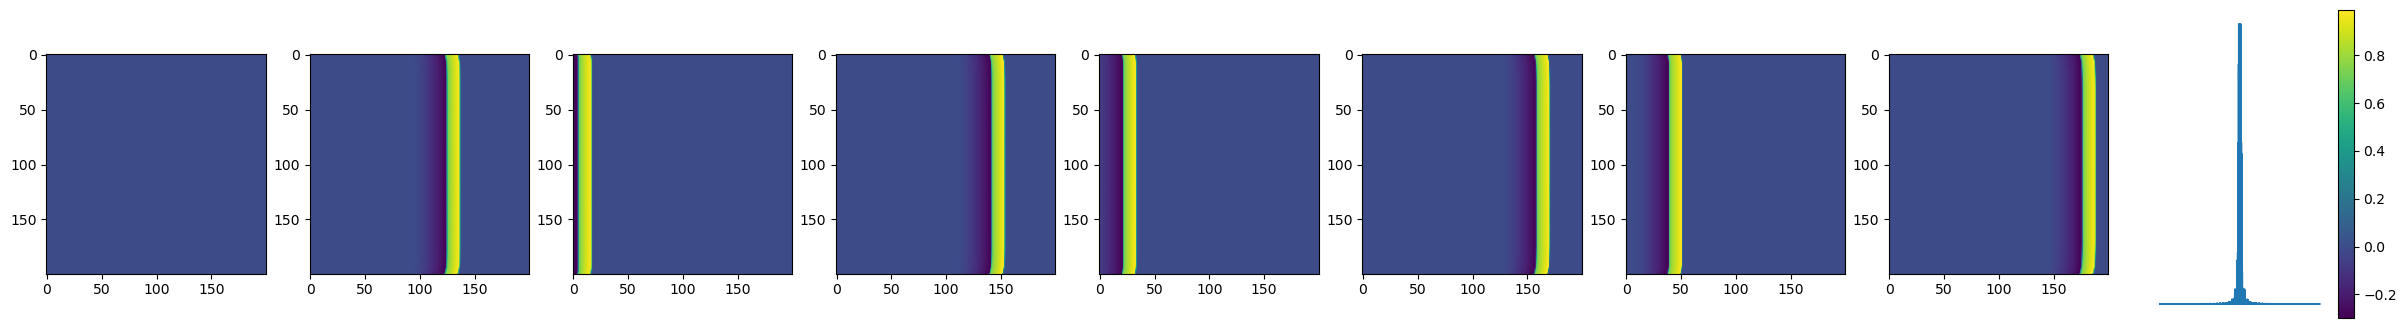

In [ ]:
L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=0, sparse_matrix=True, seed=2)
u_sol, v_sol = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=delta_t, total_time=7500, stimulus_time=1500, Nconf=5000)
fig, axs = plt.subplots(1,9,figsize=(30,4))
min = u_sol.min()
max = u_sol.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(u_sol[int((i/len(axs)*int(5000))),:].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])


pw1=process_elem(u_sol[:,20000])

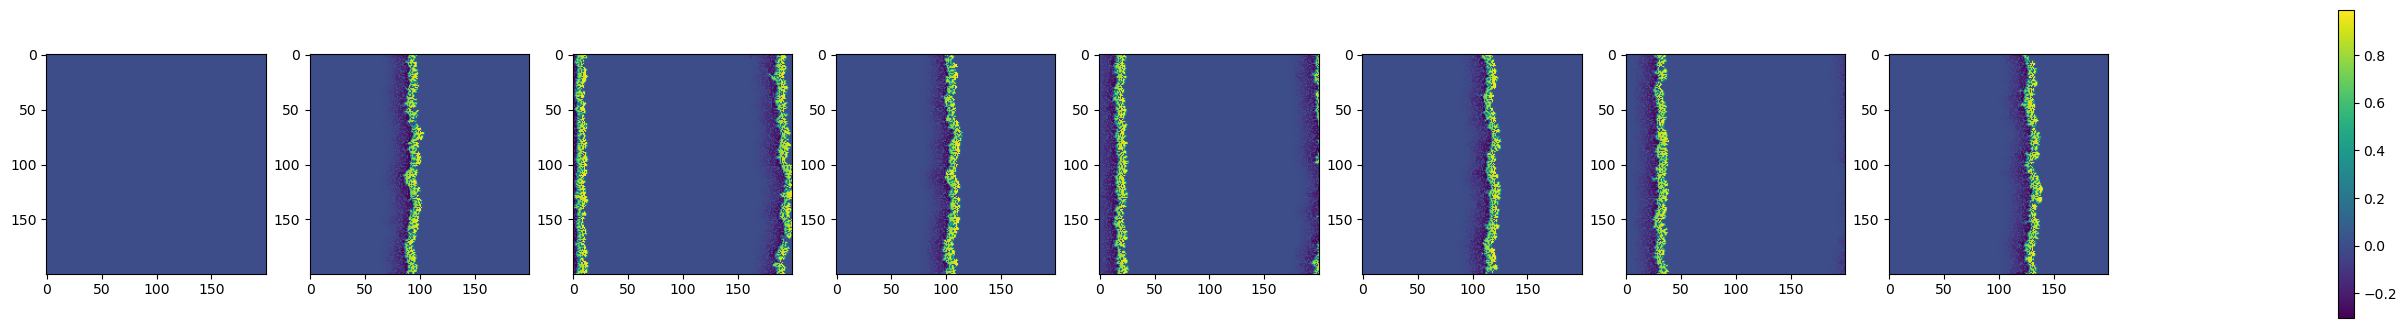

In [48]:
L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=0.3, sparse_matrix=True, seed=2)
u_sol1, v_sol1 = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=delta_t, total_time=7500, stimulus_time=1500, Nconf=5000)
fig, axs = plt.subplots(1,9,figsize=(30,4))
min = u_sol1.min()
max = u_sol1.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(u_sol1[int((i/len(axs)*int(5000))),:].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])


pw2=process_elem(u_sol1[:,20000])

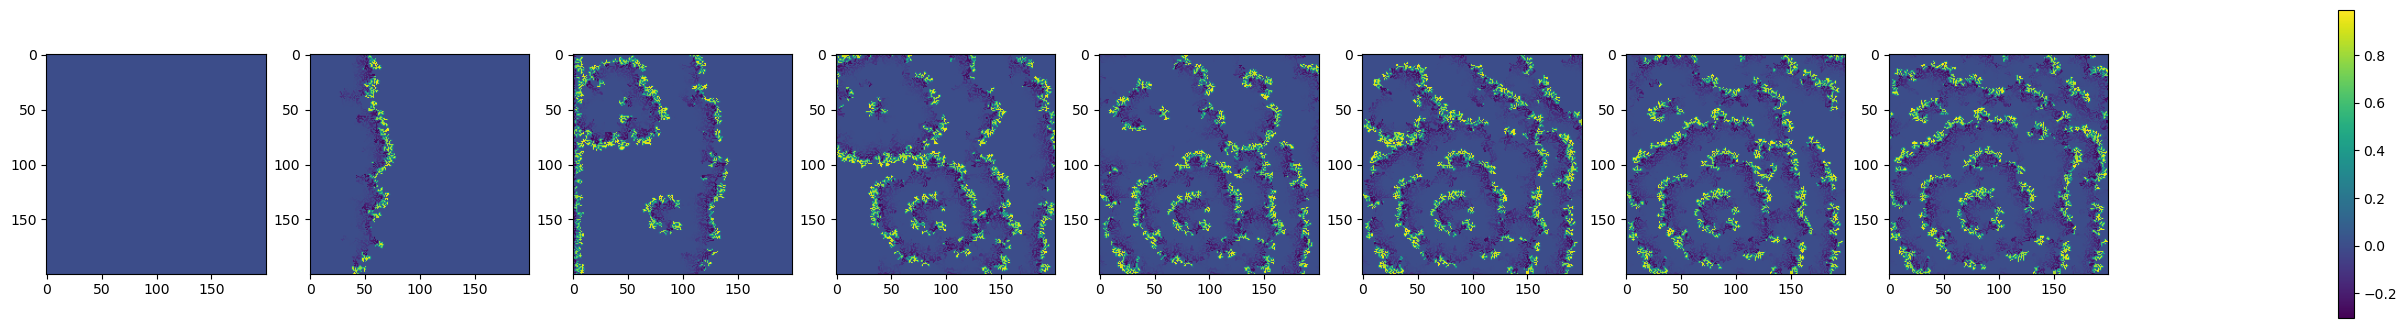

In [49]:
L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=0.5, sparse_matrix=True, seed=2)
u_sol2, v_sol2 = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=delta_t, total_time=7500, stimulus_time=1500, Nconf=5000)
fig, axs = plt.subplots(1,9,figsize=(30,4))
min = u_sol2.min()
max = u_sol2.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(u_sol2[int((i/len(axs)*int(5000))),:].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])
pw3=process_elem(u_sol2[:,20000])

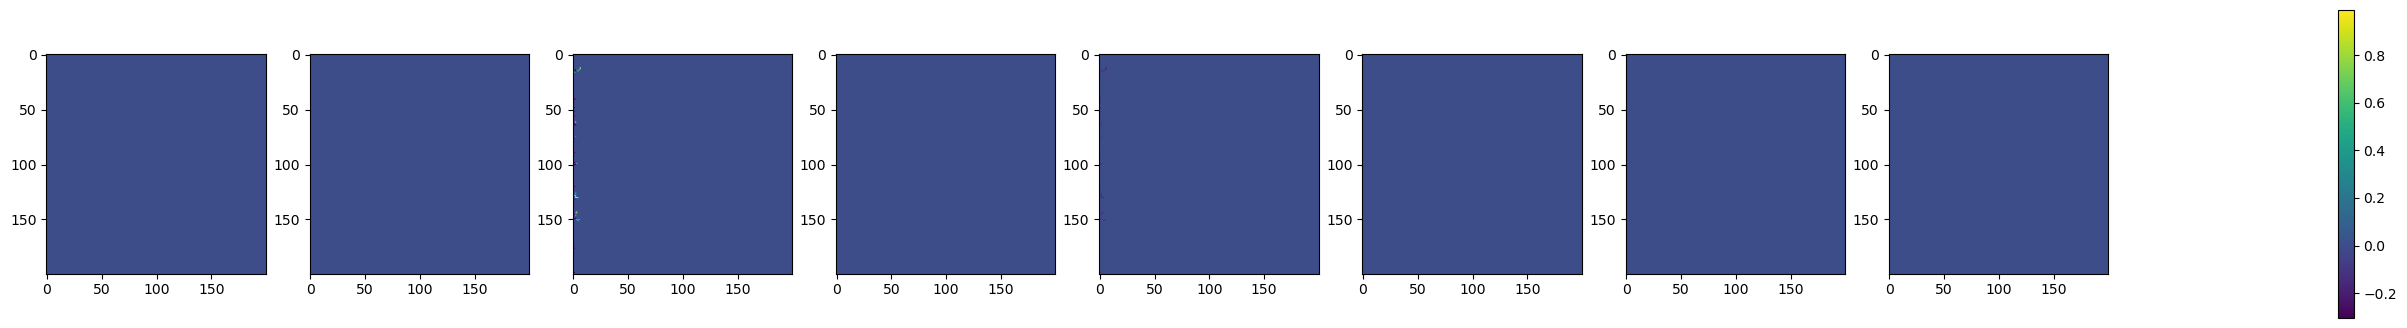

In [53]:
L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=0.8, sparse_matrix=True, seed=2)
u_sol3, v_sol3 = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=delta_t, total_time=7500, stimulus_time=1500, Nconf=5000)
fig, axs = plt.subplots(1,9,figsize=(30,4))
min = u_sol2.min()
max = u_sol3.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(u_sol3[int((i/len(axs)*int(5000))),:].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])
pw4=process_elem(u_sol3[:,20000])

In [93]:
pw1=process_elem(u_sol[:,9100])
pw2=process_elem(u_sol1[:,9100])
pw3=process_elem(u_sol2[:,9100])
pw4=process_elem(u_sol3[:,9100])

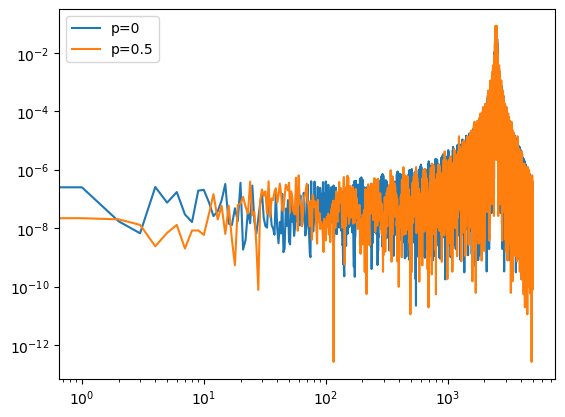

In [96]:
plt.plot(jnp.linspace(0, 5000, 5000), pw1, label='p=0')
##plt.plot(jnp.linspace(0, 5000, 5000), pw2, label='p=0.3')
plt.plot(jnp.linspace(0, 5000, 5000), pw3, label='p=0.5')
#plt.plot(jnp.linspace(0, 5000, 5000), pw4, label='p=0.8')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

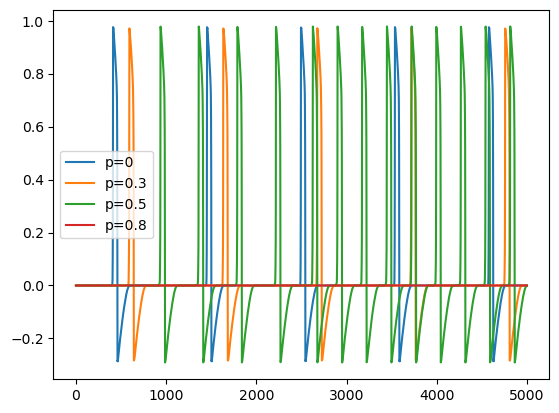

In [92]:
plt.plot(jnp.linspace(0, 5000, 5000), u_sol[:,9100], label='p=0')
plt.plot(jnp.linspace(0, 5000, 5000), u_sol1[:,9100], label='p=0.3')
plt.plot(jnp.linspace(0, 5000, 5000), u_sol2[:,9100], label='p=0.5')
plt.plot(jnp.linspace(0, 5000, 5000), u_sol3[:,9100], label='p=0.8')

plt.legend()
plt.show()

In [29]:
results_u = []
results_v=[]
# Loop over conduction threshold values
for conduction_threshold in jnp.arange(0, 0.8, 0.01):
    seed = int(conduction_threshold * 10)
    seed2=int(conduction_threshold * 100)
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=conduction_threshold, sparse_matrix=True, seed=seed)   
    
    u_sol, v_sol = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1,delta_t=delta_t, total_time=7500, stimulus_time=1500, Nconf=5000, key=random.PRNGKey(seed2))
    u_sol=u_sol.T
    v_sol=v_sol.T
    u_sol=u_sol.reshape(N_x, N_y,5000)
    v_sol=v_sol.reshape(N_x, N_y, 5000)

    
    avg_entropy_u = average_entropy(u_sol, c1)
    avg_entropy_v = average_entropy(v_sol, c1)
    
    results_u.append( avg_entropy_u)
    results_v.append(avg_entropy_v)

results_u = jnp.array(results_u)
results_v = jnp.array(results_v)

70
79


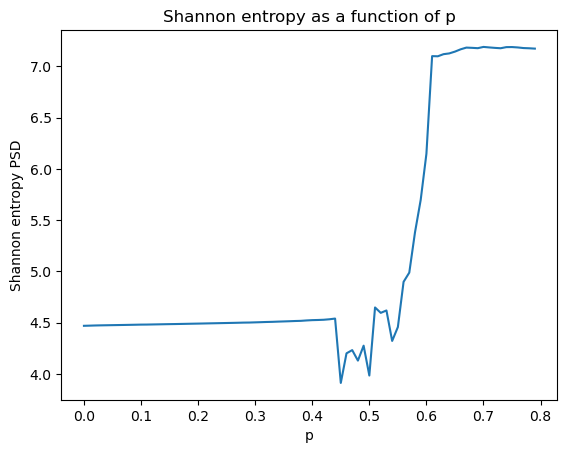

In [30]:
minu=np.min(results_u)
maxu=np.max(results_u)
#minv=np.min(entropy_v)
#maxv=np.max(entropy_v)
print(np.argmax(results_u))
print(np.argmax(results_v))
plt.plot(np.arange(0,0.8,0.01),results_u,label='Entropy of u')
##plt.plot(np.arange(0,0.80,0.01),results_v,label='Entropy of v')
plt.xlabel('p')
plt.ylabel('Shannon entropy PSD')
#plt.legend()
plt.title('Shannon entropy as a function of p')
plt.show()


In [ ]:
## saving configurations to disk to avoid memory problems
def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - Du: Diffusion coefficient
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=None, c1=None, sigma=0.0001, stimulus_time=1000, delta_t=0.1, total_time=3000.0, Ncof=100, key=random.PRNGKey(0), save_path='simulation_data'):
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)

    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    save_interval = num_steps // Ncof
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    def scan_fn(carry, step):
        u, v, key, save_counter = carry
        key, subkey = random.split(key)
        
        # Apply stimulus to the specified indices
        u = jax.lax.cond((step > 0) & (step % int(stimulus_time / delta_t) == 0),
                          lambda u: u.at[indices].add(0.1),
                          lambda u: u,
                          u)

        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        
        # Save the configuration at the specified intervals
        save_counter = save_counter + 1
        if save_counter % save_interval == 0:
            np.save(f'{save_path}/u_{save_counter // save_interval}.npy', np.array(u))
            np.save(f'{save_path}/v_{save_counter // save_interval}.npy', np.array(v))
        
        return (u, v, key, save_counter), (u, v)

    # Create the save directory if it doesn't exist
    import os
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # Run the scan function
    carry = (u, v, key, 0)
    carry, _ = lax.scan(scan_fn, carry, None, length=num_steps)

    return



In [ ]:
# Example usage
N_x = 200
N_y = 200
N = N_x * N_y
L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=0.3, sparse_matrix=True, seed=2)

#change the save path before running it
run_simulation(N=N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=L1, c1=c1, sigma=0.0001, stimulus_time=1000, delta_t=0.1, total_time=3000.0, Ncof=100, key=random.PRNGKey(0), save_path='simulation_data')

fig, axs = plt.subplots(1, 9, figsize=(30, 4))
min_val = float('inf')
max_val = float('-inf')

# Load saved configurations and find min and max values
for i in range(1, 10):
    u = np.load(f'simulation_data/u_{i}.npy')
    min_val = min(min_val, u.min())
    max_val = max(max_val, u.max())

# Plot the saved configurations
for i, ax in enumerate(axs[:-1]):
    u = np.load(f'simulation_data/u_{i+1}.npy')
    im = ax.imshow(u.reshape(N_x, N_y), vmin=min_val, vmax=max_val)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1], fraction=0.05, pad=0.04)  # Adjusted fraction for a bigger colorbar
plt.show()